# Similarity Encoders with Keras

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

import tensorflow as tf
tf.set_random_seed(28)
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation

# https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import center_K, S_ll_reg
from utils import plot_mnist, plot_20news, check_embed_match, check_similarity_match

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### MNIST with Linear Kernel

In [2]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

In [3]:
# centered linear kernel matrix
K_lin = center_K(np.dot(X, X.T))

error similarity match: msqe: 51.4531662441 ; r^2: 0.4438507851 ; rho: 0.6341602248


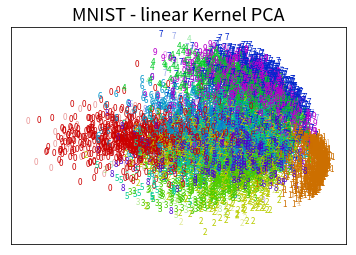

In [4]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')
print "error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)

Epoch 1/25
8000/8000 [==============================] - 6s - loss: 117.6958     
Epoch 2/25
8000/8000 [==============================] - 5s - loss: 99.7067     
Epoch 3/25
8000/8000 [==============================] - 4s - loss: 98.6022     
Epoch 4/25
8000/8000 [==============================] - 4s - loss: 97.9915     
Epoch 5/25
8000/8000 [==============================] - 5s - loss: 97.3093     
Epoch 6/25
8000/8000 [==============================] - 6s - loss: 96.3998     
Epoch 7/25
8000/8000 [==============================] - 4s - loss: 95.1263     
Epoch 8/25
8000/8000 [==============================] - 6s - loss: 93.2907     
Epoch 9/25
8000/8000 [==============================] - 5s - loss: 90.7325     
Epoch 10/25
8000/8000 [==============================] - 5s - loss: 87.5898     
Epoch 11/25
8000/8000 [==============================] - 7s - loss: 84.4039     
Epoch 12/25
8000/8000 [==============================] - 5s - loss: 81.8146     
Epoch 13/25
8000/8000 [=============

correlation with lin kPCA       : 0.980370
correlation with lin kPCA (test): 0.981807
error similarity match: msqe: 51.6587239879 ; r^2: 0.4416364618 ; rho: 0.6326249981


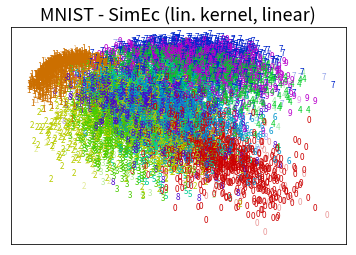

In [5]:
# on how many target similarities you want to train - faster and works equally well than training on all
n_targets = 1000  # K_lin.shape[1]
# initialize the model
model = Sequential()
# add the linear layer that maps to your embedding
model.add(Dense(2, input_shape=(X.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation('linear'))
# add another linear layer to get the linear approximation of the target similarities
model.add(Dense(n_targets, kernel_regularizer=S_ll_reg(0.5, K_lin[:n_targets,:n_targets])))
model.add(Activation('linear'))
# compile the model to minimize the MSE
opt = keras.optimizers.Adamax(lr=0.005)
model.compile(optimizer=opt, loss='mse')
# train the model to get an embedding with which the target similarities
# can be linearly approximated
model.fit(X, K_lin[:,:n_targets], epochs=25)
# after training is complete, we loose the last layer (+ activation) to only get the embedding
model2 = Sequential(model.layers[:-2])
# the (linear) activations of the second to last layer are our embedding
X_embeds = model2.predict(X)
X_embed_tests = model2.predict(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (lin. kernel, linear)')
# correlation with the embedding produced by the spectral method should be high
print "correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
# similarity match error should be similar to the one from kpca
print "error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)

### Non-linear MNIST embedding with isomap

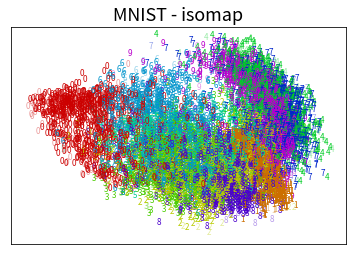

In [6]:
# isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
X_embed_test = isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')

Epoch 1/30
8000/8000 [==============================] - 1s - loss: 32.3135     
Epoch 2/30
8000/8000 [==============================] - 1s - loss: 26.0950     
Epoch 3/30
8000/8000 [==============================] - 1s - loss: 24.9986     
Epoch 4/30
8000/8000 [==============================] - 1s - loss: 24.6518     
Epoch 5/30
8000/8000 [==============================] - 1s - loss: 24.5189     
Epoch 6/30
8000/8000 [==============================] - 1s - loss: 24.4485     
Epoch 7/30
8000/8000 [==============================] - 1s - loss: 24.4044     
Epoch 8/30
8000/8000 [==============================] - 1s - loss: 24.3608     
Epoch 9/30
8000/8000 [==============================] - 1s - loss: 24.3305     
Epoch 10/30
8000/8000 [==============================] - 1s - loss: 24.3000     
Epoch 11/30
8000/8000 [==============================] - 2s - loss: 24.2744     
Epoch 12/30
8000/8000 [==============================] - 1s - loss: 24.2524     
Epoch 13/30
8000/8000 [==============

correlation with isomap       : 0.847664
correlation with isomap (test): 0.821292


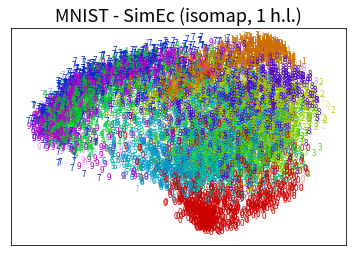

In [8]:
# non-linear SimEc to approximate isomap solution
K_geod = center_K(isomap.dist_matrix_)
# initialize the model
model = Sequential()
# optionally add some non-linear layers to the feed forward NN
model.add(Dense(20, input_shape=(X.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation('tanh'))
# add the linear layer that maps to your embedding
# in this case we want to visualize our data so the embedding dim is 2
model.add(Dense(2, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation('linear'))
# add another linear layer to get the linear approximation of the target similarities
model.add(Dense(n_targets))
model.add(Activation('linear'))
# compile the model to minimize the MSE
opt = keras.optimizers.Adamax(lr=0.005)
model.compile(optimizer=opt, loss='mse')
# train the model to get an embedding with which the target similarities
# can be linearly approximated
model.fit(X, K_geod[:,:n_targets], epochs=30)
# after training is complete, we loose the last layer (+ activation) to only get the embedding
model2 = Sequential(model.layers[:-2])
# the (linear) activations of the second to last layer are our embedding
X_embeds = model2.predict(X)
X_embed_tests = model2.predict(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (isomap, 1 h.l.)')
print "correlation with isomap       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with isomap (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]

## 20newsgroups embedding

In [9]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
target_names = newsgroups_train.target_names

3959 training and 2359 test samples
45813 features


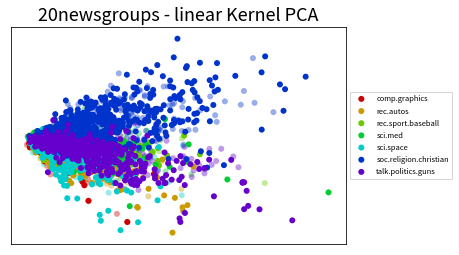

In [10]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20newsgroups - linear Kernel PCA', legend=True)

Epoch 1/20
3959/3959 [==============================] - 1s - loss: 0.0427     
Epoch 2/20
3959/3959 [==============================] - 1s - loss: 0.0353     
Epoch 3/20
3959/3959 [==============================] - 1s - loss: 0.0343     
Epoch 4/20
3959/3959 [==============================] - 1s - loss: 0.0343     
Epoch 5/20
3959/3959 [==============================] - 1s - loss: 0.0343     
Epoch 6/20
3959/3959 [==============================] - 1s - loss: 0.0342     
Epoch 7/20
3959/3959 [==============================] - 1s - loss: 0.0339     
Epoch 8/20
3959/3959 [==============================] - 1s - loss: 0.0335     
Epoch 9/20
3959/3959 [==============================] - 1s - loss: 0.0334     
Epoch 10/20
3959/3959 [==============================] - 1s - loss: 0.0334     
Epoch 11/20
3959/3959 [==============================] - 1s - loss: 0.0334     
Epoch 12/20
3959/3959 [==============================] - 1s - loss: 0.0333     
Epoch 13/20
3959/3959 [==========================

correlation with lin kPCA       : 0.992638
correlation with lin kPCA (test): 0.996063


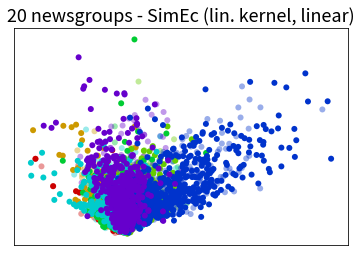

In [11]:
# compute linear kernel and center
K_lin = center_K(X.dot(X.T).A)
# project to 2d with linear similarity encoder
# careful: our input is sparse!!!
inputs = Input(shape=(X.shape[1],), sparse=True)
# layer for the 2d embedding
embedding = Dense(2, activation='linear')(inputs)
# layer for the predicted similarities
outputs = Dense(K_lin.shape[1], activation='linear')(embedding)
# put it all into a model
model = Model(inputs=inputs, outputs=outputs)
# compile the model to minimize the MSE
opt = keras.optimizers.SGD(lr=50.)
model.compile(optimizer=opt, loss='mse')
# train the model to get an embedding with which the target similarities
# can be linearly approximated
model.fit(X, K_lin, epochs=20)
# after training is complete, we loose the last layer (+ activation) to only get the embedding
model2 = Model(inputs=inputs, outputs=embedding)
# the (linear) activations of the second to last layer are our embedding
X_embeds = model2.predict(X)
X_embed_tests = model2.predict(X_test)
plot_20news(X_embeds, y, target_names, X_embed_tests, y_test,
            title='20 newsgroups - SimEc (lin. kernel, linear)')
print "correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]